### Udacity Data Science Nanodegree
### Project 1: Writing a Data Scientist Blog Post
---

# Part II - London Airbnb Data - EDA
## by Juanita Smith


- [Introduction](#intro)
- [Data gathering](#getdata)
- [Feature Engineering](#featureeng)
- [Step 1: Univariate Exploratoin](#univariate)
- [Step 2: Bivariate Exploratoin](#bivariate)
- [Step 3: Multivariate Exploratoin](#multivariate)
- [Conclusions](#conclusions)
- [References](#references)
- [Submission](#submission)

<a id='intro'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Introduction</span>

### Context:
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in London, United Kingdom.


### Dictionary:

In Part I, Airbnb London listing data was cleaned, and only a subset of the available features was selected to support analysis of below questions.

**Recap of the origin of data:**

Airbnb activity is included for **London** and is a snapshot of booking availability on 8 June 2023

Data was downloaded from Airbnb [here](http://insideairbnb.com/get-the-data/). Scroll down to London section. 

To support this analysis, only listings and calendar data was needed.

Metadata are available [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596)

## Are you like me going the Taylor Swift concert in London next June and looking for the best place to stay ?

This project will focus on answering questions below, whilst this notebook focus on questions 2 and 3 in blue

#### 1) Are some hosts running a business, and if so, what is the impact on price ?
> - Can we identify businesses by the duration of rentals ? Are businesses focusing on short or long term term rentals? What impact have rental duration have on price ?
> - Are some hosts running a business with multiple listings ? If so, how does this affect the price ?

<span style="color:blue; font-size:20px; line-height:20px; font-family: Calibri;">2) Host Analysis: How does **host excellence** influence price ?</span>
> - Super hosts seems to describe their properties better, how does this effect price and availability ?


<span style="color:blue; font-size:20px; line-height:20px; font-family: Calibri;">3) What effect does **star ratings** have on rental price ?</span>
> - Would a 5-star vs 3-star listing in the same location cost more ?


#### 4) Predict average daily listing price
> - Knowing the impact of host excellence and star ratings above, could we make an accurate average daily price prediction ?


## 2) Host Analysis: How does **host excellence** influence price ?

### Main feature(s) of interest

> I would expect commercial rentals to be lower in price per day, with a minimum rental period for longer periods 3 months and more

We are looking to classify rentals between individual or commercial rentals.

Main features of interest to help detect commercial rentals:
- What is the price impact on superhosts
- Which other features impact price ?
- Which correlations exists ?

In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import os
import missingno as msno
from datetime import datetime

# fuzzy compare neighborhood strings
from fuzzywuzzy import fuzz

# Entity recognition: is the host a person or business ?
import stanza

# from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer

# clear the garbage to free memory as we are working with huge datasets
import gc 

# import warnings
# warnings.filterwarnings("ignore")

# Import custom modules
from project1_blog.src.utils import reduce_mem_usage, create_folder, entity_recognision
import project1_blog.src.visuals as vs

# set plots to be embedded inline
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# # use high resolution if this project is run on an apple device
# %config InlineBackend.figure_format='retina'

# Make your Jupyter Notebook wider
from IPython.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))

# environment settings
# display all columns and rows during visual inspection
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# stop scientific notation on graphs
# pd.options.display.float_format = '{:.0f}'.format

In [2]:
# set default plot formatting and colors
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_SUB1, BASE_COLOR_SUB2, SYMBOLS = vs.set_plot_defaults()

In [3]:
# default file paths
# FILE_NAME_RAW = '../data/clean/listing_clean.pkl'
# FILE_NAME_CLEAN = '../data/clean/listing_clean.pkl'
FILE_NAME_ENHANCED = '../data/clean/listing_enhanced.pkl'

<a id='getdata'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Gather Data</span>

In [4]:
# load the enhanced listing file 
listings = pd.read_pickle(FILE_NAME_ENHANCED)
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68923 entries, 0 to 69184
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   listing_id                                    68923 non-null  int64   
 1   listing_url                                   68923 non-null  object  
 2   name                                          68923 non-null  object  
 3   host_id                                       68923 non-null  int64   
 4   host_name                                     68923 non-null  object  
 5   host_response_time                            51806 non-null  object  
 6   host_response_rate                            68923 non-null  int16   
 7   host_acceptance_rate                          68923 non-null  int16   
 8   host_is_superhost                             68923 non-null  bool    
 9   host_neighbourhood                            68923 non

In [5]:
host_features = ['host_id', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'number_of_reviews_ltm', 'number_of_reviews',
                 'review_scores_rating', 'host_years_active', 'host_has_about', 'host_has_neighborhood_overview', 'is_business', 'price_mean', 'room_type', 'property_type', 'availability_365', 'availability_30', 'availability_60']

In [6]:
host = listings[host_features].copy()
host.sample(5)

,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,number_of_reviews_ltm,number_of_reviews,review_scores_rating,host_years_active,host_has_about,host_has_neighborhood_overview,is_business,price_mean,room_type,property_type,availability_365,availability_30,availability_60
41366,439074505,within an hour,81,99,False,True,True,1,1,1.00,1,True,False,True,100,Entire home/apt,Entire rental unit,364,29,59
8789,83930302,within an hour,100,95,False,True,True,5,36,4.64,7,False,True,False,550,Entire home/apt,Entire townhouse,277,3,10
66899,168699679,within an hour,100,96,False,True,True,0,0,NaN,5,True,False,False,54,Private room,Private room in rental unit,56,8,32
9757,59761270,NaN,0,0,False,True,False,0,2,5.00,7,False,False,False,55,Private room,Private room in townhouse,0,0,0
51163,28229051,within a few hours,100,83,True,True,True,6,6,4.83,8,True,True,False,174,Entire home/apt,Entire condo,304,3,25


In [7]:
# make sure datatypes were preserved from cleaning step
host.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 68923 entries, 0 to 69184
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_id                         68923 non-null  int64  
 1   host_response_time              51806 non-null  object 
 2   host_response_rate              68923 non-null  int16  
 3   host_acceptance_rate            68923 non-null  int16  
 4   host_is_superhost               68923 non-null  bool   
 5   host_has_profile_pic            68923 non-null  bool   
 6   host_identity_verified          68923 non-null  bool   
 7   number_of_reviews_ltm           68923 non-null  int64  
 8   number_of_reviews               68923 non-null  int64  
 9   review_scores_rating            48640 non-null  float64
 10  host_years_active               68923 non-null  int64  
 11  host_has_about                  68923 non-null  bool   
 12  host_has_neighborhood_overview  68923

In [8]:
star_features = ['host_id', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'number_of_reviews_ltm', 
                 'review_scores_rating', 'host_years_active', 'host_has_about', 'host_has_neighborhood_overview', 'is_business', 'price_mean', 'room_type', 'property_type', 'availability']

<a id='featureeng'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Feature engineering</span>

In [9]:
# not all hosts have reviews or response rates, for this analysis lets drop nulls
host = host.dropna()
host.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40900 entries, 0 to 69077
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_id                         40900 non-null  int64  
 1   host_response_time              40900 non-null  object 
 2   host_response_rate              40900 non-null  int16  
 3   host_acceptance_rate            40900 non-null  int16  
 4   host_is_superhost               40900 non-null  bool   
 5   host_has_profile_pic            40900 non-null  bool   
 6   host_identity_verified          40900 non-null  bool   
 7   number_of_reviews_ltm           40900 non-null  int64  
 8   number_of_reviews               40900 non-null  int64  
 9   review_scores_rating            40900 non-null  float64
 10  host_years_active               40900 non-null  int64  
 11  host_has_about                  40900 non-null  bool   
 12  host_has_neighborhood_overview  40900

In [10]:
# check for duplicated host data
host.host_id.duplicated().sum()

19339

In [11]:
# which host data are duplicated ?
host[host['host_id'] == 129230780]

,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,number_of_reviews_ltm,number_of_reviews,review_scores_rating,host_years_active,host_has_about,host_has_neighborhood_overview,is_business,price_mean,room_type,property_type,availability_365,availability_30,availability_60
28776,129230780,within an hour,90,76,False,True,True,0,1,4.00,6,True,True,True,1880,Entire home/apt,Entire rental unit,179,29,59
30385,129230780,within an hour,90,76,False,True,True,0,8,4.75,6,True,True,True,1570,Entire home/apt,Entire rental unit,0,0,0
31310,129230780,within an hour,90,76,False,True,True,3,4,3.75,6,True,True,True,1570,Entire home/apt,Entire rental unit,355,20,50
32005,129230780,within an hour,90,76,False,True,True,0,1,3.00,6,True,True,True,1570,Private room,Private room in rental unit,364,29,59
32006,129230780,within an hour,90,76,False,True,True,0,3,2.67,6,True,True,True,1570,Private room,Private room in rental unit,364,29,59
32015,129230780,within an hour,90,76,False,True,True,1,1,3.00,6,True,True,True,1570,Private room,Private room in rental unit,364,29,59
32017,129230780,within an hour,90,76,False,True,True,2,2,3.00,6,True,True,True,1570,Private room,Private room in rental unit,364,29,59
32026,129230780,within an hour,90,76,False,True,True,1,1,3.00,6,True,True,True,1570,Private room,Private room in rental unit,364,29,59
32028,129230780,within an hour,90,76,False,True,True,2,2,4.00,6,True,True,True,1570,Private room,Private room in rental unit,364,29,59
32038,129230780,within an hour,90,76,False,True,True,1,2,3.00,6,True,True,True,1570,Private room,Private room in rental unit,364,29,59


In [12]:
host = pd.get_dummies(host, prefix=None, prefix_sep='_', dummy_na=False, columns=['host_response_time'], sparse=False, drop_first=False, dtype=None)
host.head()

,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,number_of_reviews_ltm,number_of_reviews,review_scores_rating,host_years_active,host_has_about,host_has_neighborhood_overview,is_business,price_mean,room_type,property_type,availability_365,availability_30,availability_60,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
0,757377,90,68,False,True,True,10,175,4.71,12,True,True,False,70,Private room,Private room in townhouse,67,10,37,False,False,True,False
1,54730,100,78,False,True,True,15,41,4.80,14,True,True,False,79,Private room,Private room in rental unit,353,23,48,False,False,False,True
2,60302,100,47,False,True,True,5,94,4.80,14,True,True,False,107,Entire home/apt,Entire rental unit,70,0,2,False,True,False,False
3,1573870,100,100,False,True,True,0,20,4.32,11,True,True,False,198,Entire home/apt,Entire rental unit,4,4,4,False,True,False,False
4,766056,100,68,False,True,True,4,96,4.72,12,True,True,False,62,Private room,Private room in rental unit,160,1,1,False,False,False,True


In [13]:
# host_features = host_features.remove('host_response_time')

# enhance columns of interest

host_features_reduced = host_features.copy()
remove_list = ['host_id', 'host_response_time', 'room_type', 'property_type']

host_features_reduced = [i for i in host_features if i not in remove_list]
# try:
#     host_features_reduced.remove()        
# #     host_features.remove()
# #     cols_of_interest.append('is_business')
# except ValueError:
#     pass   

host_features_reduced

['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'number_of_reviews_ltm',
 'number_of_reviews',
 'review_scores_rating',
 'host_years_active',
 'host_has_about',
 'host_has_neighborhood_overview',
 'is_business',
 'price_mean',
 'availability_365',
 'availability_30',
 'availability_60']

In [14]:
# summarize host data
host_grouped = host.groupby(['host_id'], as_index=False).mean(numeric_only=True)
host_grouped.head()

,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,number_of_reviews_ltm,number_of_reviews,review_scores_rating,host_years_active,host_has_about,host_has_neighborhood_overview,is_business,price_mean,availability_365,availability_30,availability_60,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
0,4775,100.0,96.0,0.0,1.0,1.0,26.428571,127.000000,4.792857,15.0,1.0,1.000000,0.0,154.714286,210.142857,4.428571,10.000000,0.0,0.0,0.0,1.0
1,4879,100.0,33.0,0.0,1.0,1.0,3.000000,3.000000,4.670000,15.0,1.0,1.000000,0.0,175.000000,364.000000,29.000000,59.000000,0.0,0.0,1.0,0.0
2,6774,100.0,92.0,0.0,1.0,1.0,8.500000,23.333333,4.776667,14.0,1.0,0.833333,0.0,145.000000,74.000000,0.666667,3.666667,0.0,0.0,0.0,1.0
3,10657,90.0,97.0,0.0,1.0,1.0,8.500000,37.500000,4.770000,14.0,1.0,1.000000,0.0,119.000000,70.000000,0.500000,6.000000,0.0,0.0,1.0,0.0
4,23386,100.0,0.0,0.0,1.0,1.0,0.000000,7.000000,5.000000,14.0,1.0,0.000000,0.0,195.000000,288.000000,0.000000,0.000000,0.0,0.0,0.0,1.0


In [15]:
# make sure host data are summarized correctly
host_grouped[host_grouped['host_id'] == 129230780]

,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,number_of_reviews_ltm,number_of_reviews,review_scores_rating,host_years_active,host_has_about,host_has_neighborhood_overview,is_business,price_mean,availability_365,availability_30,availability_60,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
13243,129230780,90.0,76.0,0.0,1.0,1.0,1.87013,2.38961,3.569351,6.0,1.0,0.961039,1.0,1550.168831,279.376623,16.649351,40.103896,0.0,0.0,0.0,1.0


In [16]:
# how many unique hosts will we analyze ?
host_grouped.shape

(21561, 21)

<a id='univariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Univariate Analysis</span>

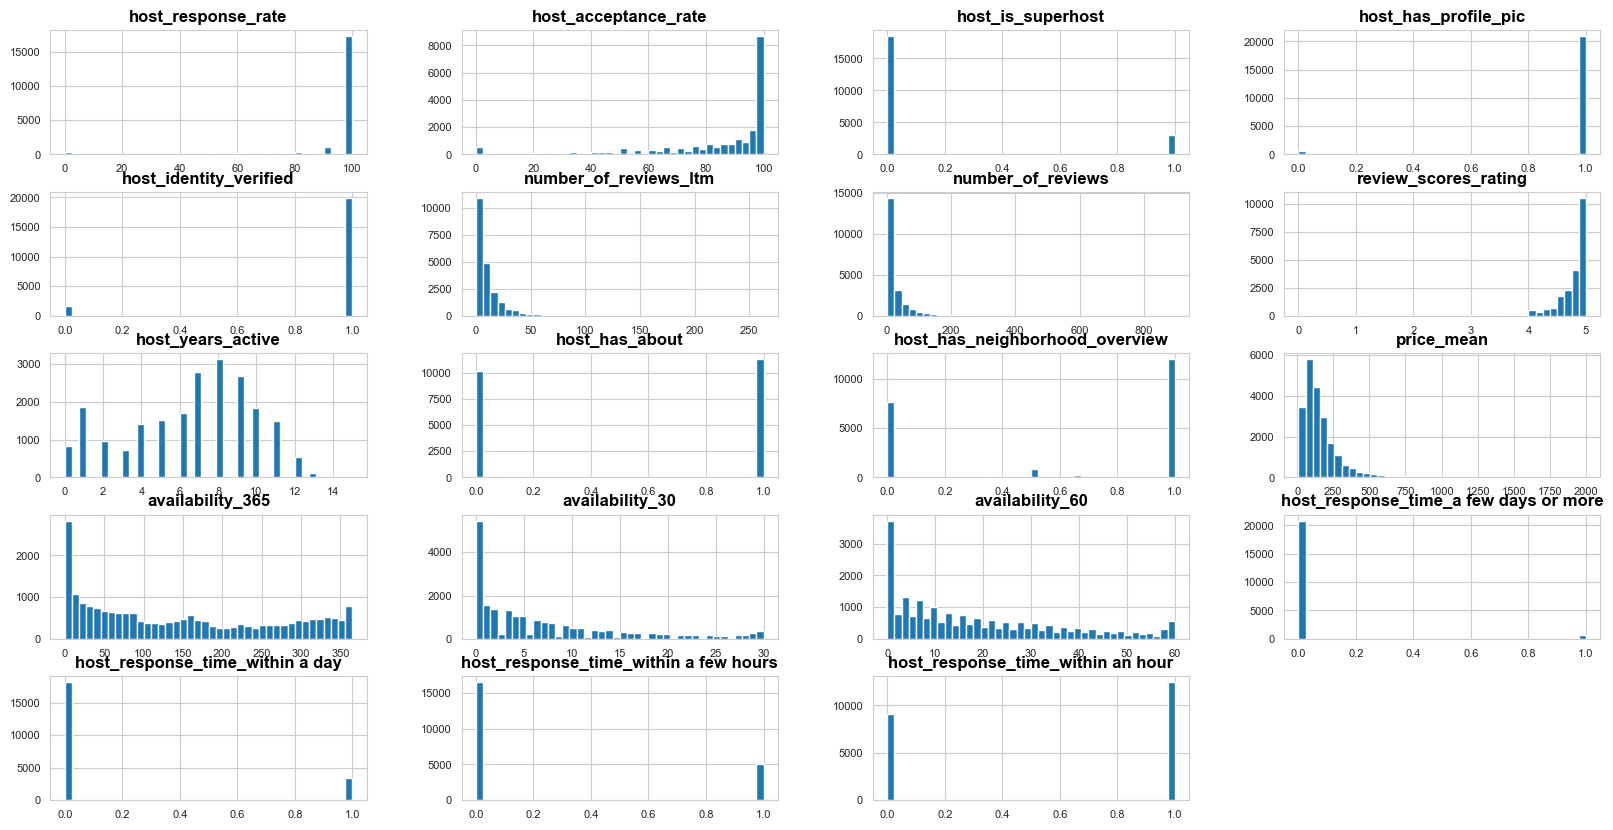

In [17]:
# get a general idea of numeric feature distributions
pd.plotting.hist_frame(host_grouped.drop(['host_id', 'is_business'], axis=1), figsize=(20,10), bins=40);

In [18]:
host_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21561 entries, 0 to 21560
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   host_id                                21561 non-null  int64  
 1   host_response_rate                     21561 non-null  float64
 2   host_acceptance_rate                   21561 non-null  float64
 3   host_is_superhost                      21561 non-null  float64
 4   host_has_profile_pic                   21561 non-null  float64
 5   host_identity_verified                 21561 non-null  float64
 6   number_of_reviews_ltm                  21561 non-null  float64
 7   number_of_reviews                      21561 non-null  float64
 8   review_scores_rating                   21561 non-null  float64
 9   host_years_active                      21561 non-null  float64
 10  host_has_about                         21561 non-null  float64
 11  ho

<a id='bivariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Bivariate Analysis</span>

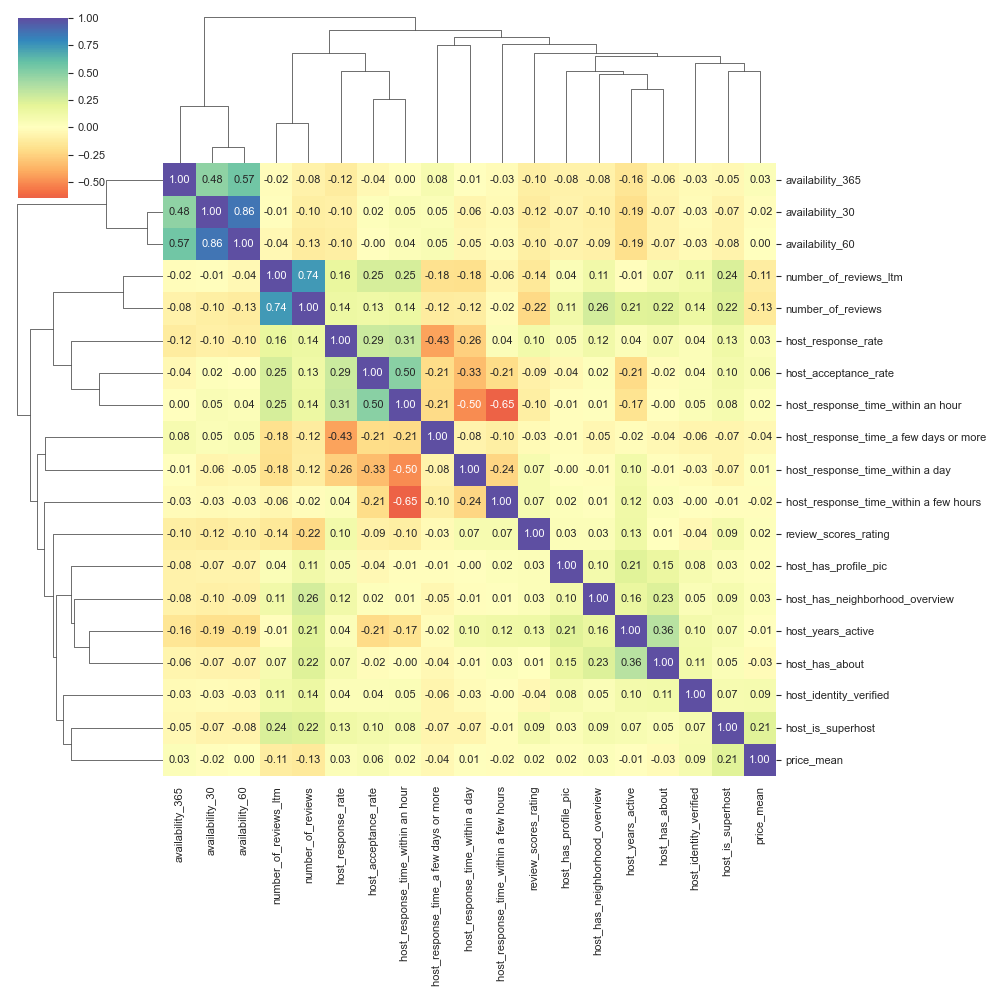

In [19]:
sns.clustermap(host_grouped.drop(['host_id', 'is_business'], axis=1).corr(method='spearman'), cmap="Spectral", center=0, annot=True, fmt='.2f');

In [20]:
host_grouped = host_grouped[host_grouped['is_business'] == False]
host = host[host['is_business'] == False]
host_grouped.head()

,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,number_of_reviews_ltm,number_of_reviews,review_scores_rating,host_years_active,host_has_about,host_has_neighborhood_overview,is_business,price_mean,availability_365,availability_30,availability_60,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
0,4775,100.0,96.0,0.0,1.0,1.0,26.428571,127.000000,4.792857,15.0,1.0,1.000000,0.0,154.714286,210.142857,4.428571,10.000000,0.0,0.0,0.0,1.0
1,4879,100.0,33.0,0.0,1.0,1.0,3.000000,3.000000,4.670000,15.0,1.0,1.000000,0.0,175.000000,364.000000,29.000000,59.000000,0.0,0.0,1.0,0.0
2,6774,100.0,92.0,0.0,1.0,1.0,8.500000,23.333333,4.776667,14.0,1.0,0.833333,0.0,145.000000,74.000000,0.666667,3.666667,0.0,0.0,0.0,1.0
3,10657,90.0,97.0,0.0,1.0,1.0,8.500000,37.500000,4.770000,14.0,1.0,1.000000,0.0,119.000000,70.000000,0.500000,6.000000,0.0,0.0,1.0,0.0
4,23386,100.0,0.0,0.0,1.0,1.0,0.000000,7.000000,5.000000,14.0,1.0,0.000000,0.0,195.000000,288.000000,0.000000,0.000000,0.0,0.0,0.0,1.0


#### What makes a superhost great ?

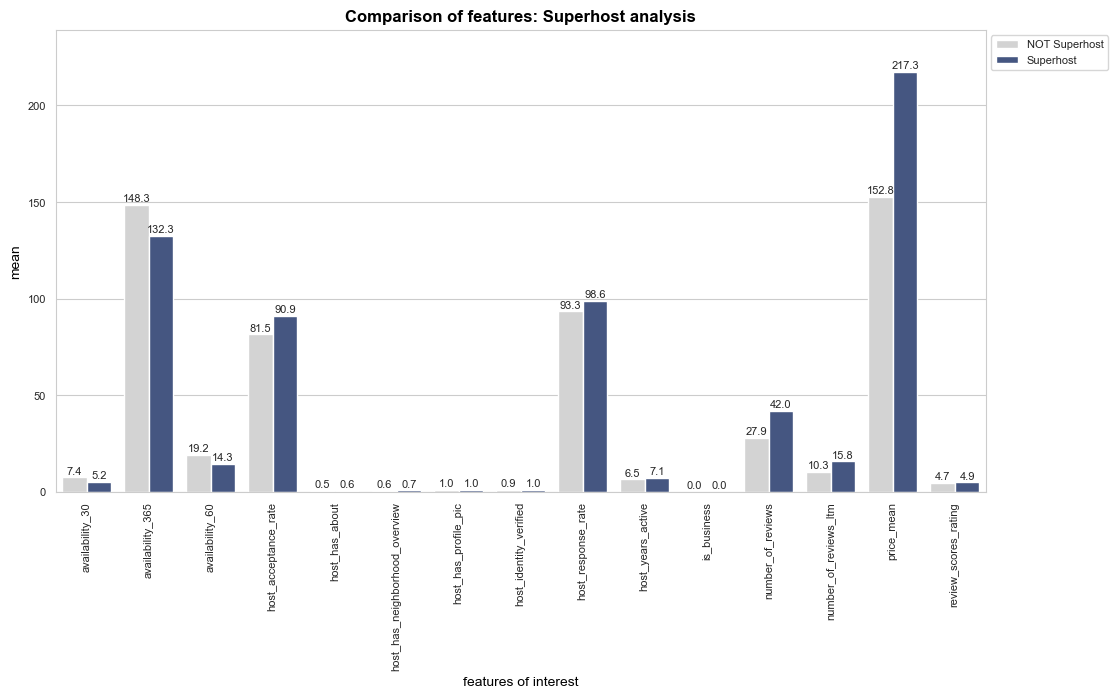

In [21]:
vs.compare_features(host_grouped, host_features_reduced.copy(), conda='host_is_superhost == False', condb='host_is_superhost == True', cata_description='NOT Superhost', catb_description='Superhost', 
                    title_extension='Superhost analysis', feature_focus='host_is_superhost')

#### Compare prices for room types between hosts and superhosts

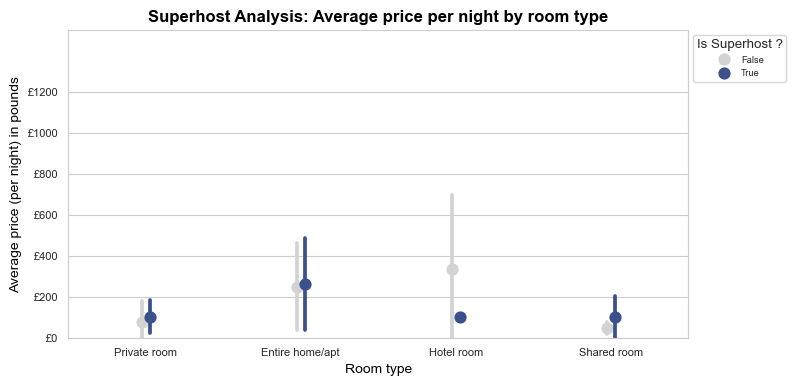

In [22]:
plt.figure(figsize=(8,4))
g = sns.pointplot(data=host, x='room_type', y='price_mean', hue='host_is_superhost', dodge=True, palette={True: BASE_COLOR, False: BASE_GREY}, 
                  errorbar='sd', linestyles="", marker='o')
plt.title('Superhost Analysis: Average price per night by room type')
plt.ylabel('Average price (per night) in pounds')
plt.xlabel('Room type')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Is Superhost ?', fontsize='small', title_fontsize='large')

plt.ylim(0, 1500)
yticks = np.arange(0, 1400, 200)
ylabels = ['£{:1.0f}'.format(tick) for tick in yticks] 
plt.yticks(yticks, ylabels)

plt.show()

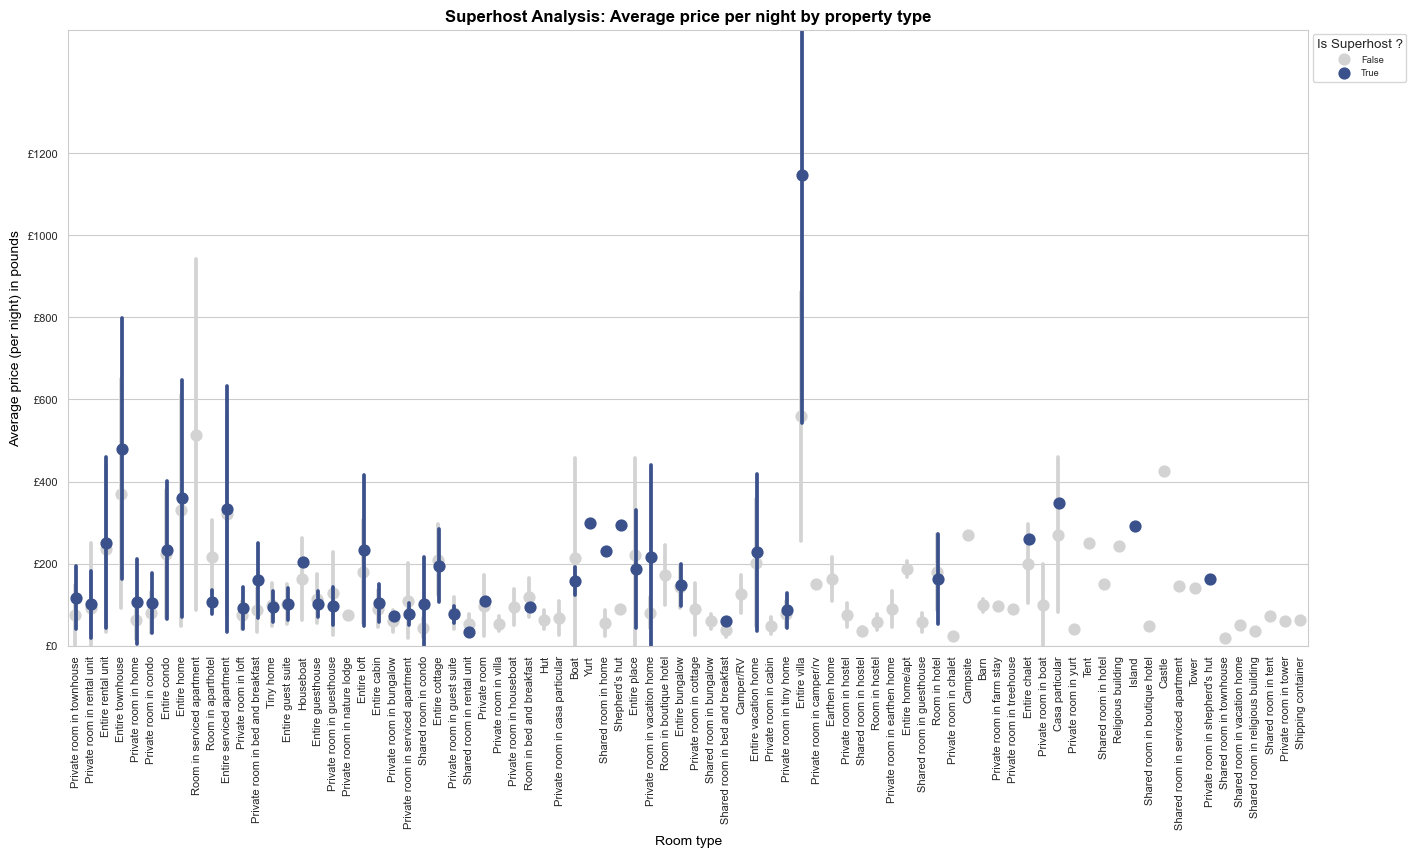

In [23]:
plt.figure(figsize=(16,8))
g = sns.pointplot(data=host, x='property_type', y='price_mean', hue='host_is_superhost', dodge=True, palette={True: BASE_COLOR, False: BASE_GREY}, 
                  errorbar='sd', linestyles="", marker='o')
plt.title('Superhost Analysis: Average price per night by property type')
plt.ylabel('Average price (per night) in pounds')
plt.xlabel('Room type')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Is Superhost ?', fontsize='small', title_fontsize='large')

plt.xticks(rotation=90)
plt.ylim(0, 1500)
yticks = np.arange(0, 1400, 200)
ylabels = ['£{:1.0f}'.format(tick) for tick in yticks] 
plt.yticks(yticks, ylabels)

plt.show()

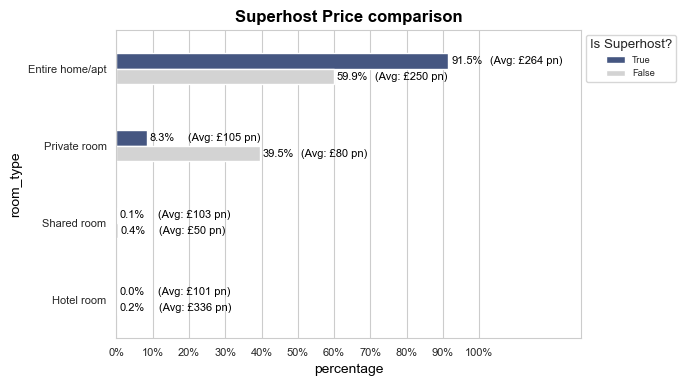

In [24]:
# compare room types
df_superhost = host[host['host_is_superhost'] == True]
df_notsuperhost = host[host['host_is_superhost'] == False]
vs.annotate_grouped_barplot(df_superhost, df_notsuperhost, hue='host_is_superhost', x='room_type', 
                            y='percentage', figsize=(6,4), title='Superhost Price comparison', legend_title='Is Superhost?')

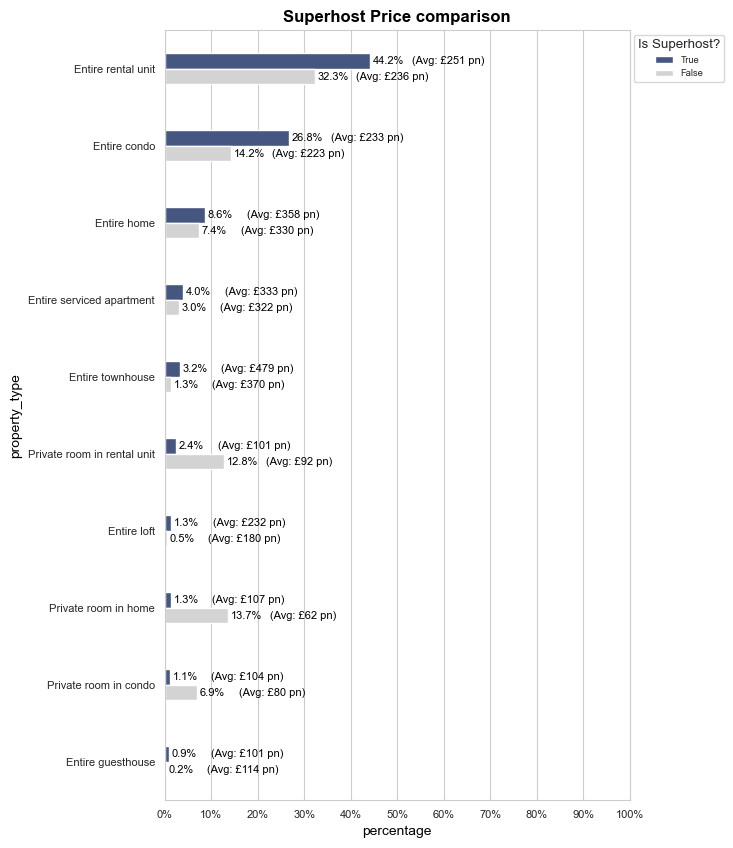

In [25]:
# compare property types
vs.annotate_grouped_barplot(df_superhost, df_notsuperhost, hue='host_is_superhost', x='property_type', 
                            y='percentage', title='Superhost Price comparison', legend_title='Is Superhost?')

<span style="color:blue; font-size:16px; font-family: Calibri;">What effect does **star ratings** have on rental price ?</span>

In [26]:
star_features = ['host_is_superhost', 'is_business', 'price_mean', 'availability_365', 'availability_90', 'availability_60', 'availability_30',
                 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

In [27]:
stars = listings[star_features].copy()
stars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68923 entries, 0 to 69184
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            68923 non-null  bool   
 1   is_business                  68923 non-null  bool   
 2   price_mean                   68923 non-null  int64  
 3   availability_365             68923 non-null  int64  
 4   availability_90              68923 non-null  int64  
 5   availability_60              68923 non-null  int64  
 6   availability_30              68923 non-null  int64  
 7   review_scores_rating         48640 non-null  float64
 8   review_scores_accuracy       47724 non-null  float64
 9   review_scores_cleanliness    47733 non-null  float64
 10  review_scores_checkin        47721 non-null  float64
 11  review_scores_communication  47726 non-null  float64
 12  review_scores_location       47720 non-null  float64
 13  review_scores_value  

In [28]:
stars.dropna(inplace=True)
stars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47714 entries, 0 to 69077
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            47714 non-null  bool   
 1   is_business                  47714 non-null  bool   
 2   price_mean                   47714 non-null  int64  
 3   availability_365             47714 non-null  int64  
 4   availability_90              47714 non-null  int64  
 5   availability_60              47714 non-null  int64  
 6   availability_30              47714 non-null  int64  
 7   review_scores_rating         47714 non-null  float64
 8   review_scores_accuracy       47714 non-null  float64
 9   review_scores_cleanliness    47714 non-null  float64
 10  review_scores_checkin        47714 non-null  float64
 11  review_scores_communication  47714 non-null  float64
 12  review_scores_location       47714 non-null  float64
 13  review_scores_value  

In [29]:
star_ratings = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
for col in star_ratings:
    stars[col] = stars[col].astype('float')

In [30]:
stars.describe()

,price_mean,availability_365,availability_90,availability_60,availability_30,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,47714.000000,47714.000000,47714.000000,47714.000000,47714.000000,47714.000000,47714.000000,47714.000000,47714.000000,47714.000000,47714.000000,47714.000000
mean,192.079725,146.013036,33.471329,18.752379,7.160267,4.619664,4.677960,4.597316,4.752976,4.767595,4.709246,4.553405
std,206.320008,128.459185,29.547730,18.784333,8.748700,0.556092,0.534117,0.580823,0.485830,0.492475,0.441407,0.564480
min,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.000000,19.000000,4.000000,1.000000,0.000000,4.500000,4.600000,4.500000,4.720000,4.750000,4.620000,4.430000
50%,131.000000,117.000000,28.000000,13.000000,4.000000,4.800000,4.860000,4.780000,4.920000,4.940000,4.830000,4.700000
75%,229.000000,274.000000,59.000000,32.000000,11.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.900000
max,2000.000000,365.000000,90.000000,60.000000,30.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


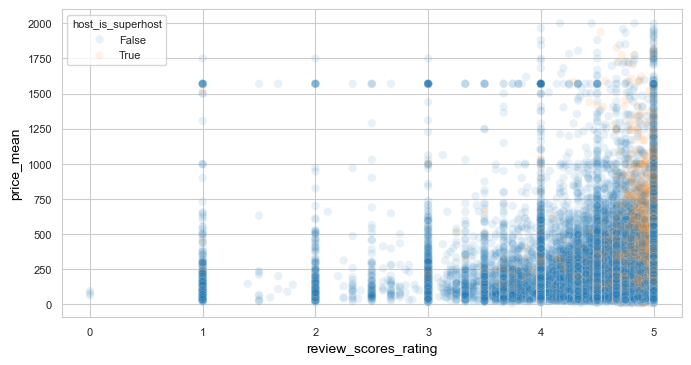

In [31]:
sns.scatterplot(data=stars, x='review_scores_rating', y='price_mean' ,hue='host_is_superhost', alpha=0.1)
plt.show()

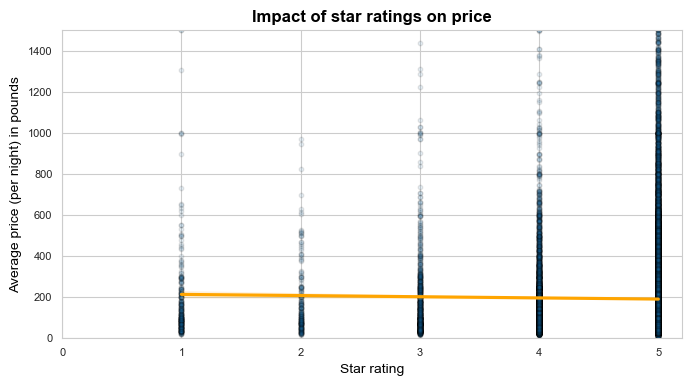

In [35]:
#  Looks like minimum nights are condensed around 60 and 90 days, lets make weekly intervals instead
bin_edges = np.arange(0, 6, 1)
bin_labels = bin_edges[1:]
stars['review_scores_rating_ranges'] = pd.cut(stars['review_scores_rating'], 
                                                  bins=bin_edges,
                                                  include_lowest=True,
                                                  labels=bin_labels)


ticks = np.arange(0, 6, 1)

sns.regplot(data=stars, x='review_scores_rating_ranges', y='price_mean', fit_reg=True, truncate=True, 
            scatter_kws={'alpha':0.1, 's':10, 'edgecolor':'black'}, line_kws={'color': 'orange'})

plt.xticks(ticks, ticks)
plt.xlabel('Star rating')
plt.ylabel('Average price (per night) in pounds')
plt.title('Impact of star ratings on price')

plt.ylim(0, 1500)

plt.show()

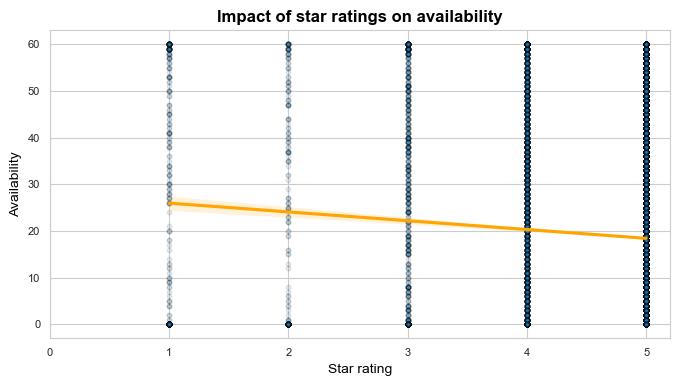

In [38]:
#  Looks like minimum nights are condensed around 60 and 90 days, lets make weekly intervals instead
bin_edges = np.arange(0, 6, 1)
bin_labels = bin_edges[1:]
stars['review_scores_rating_ranges'] = pd.cut(stars['review_scores_rating'], 
                                                  bins=bin_edges,
                                                  include_lowest=True,
                                                  labels=bin_labels)


xticks = np.arange(0, 6, 1)
yticks = np.arange(0, 70, 10)

sns.regplot(data=stars, x='review_scores_rating_ranges', y='availability_60', fit_reg=True, truncate=True,
            scatter_kws={'alpha':0.1, 's':10, 'edgecolor':'black'}, line_kws={'color': 'orange'})

plt.xticks(xticks, xticks)
plt.yticks(yticks, yticks)
plt.xlabel('Star rating')
plt.ylabel('Availability')
plt.title('Impact of star ratings on availability')

plt.show()

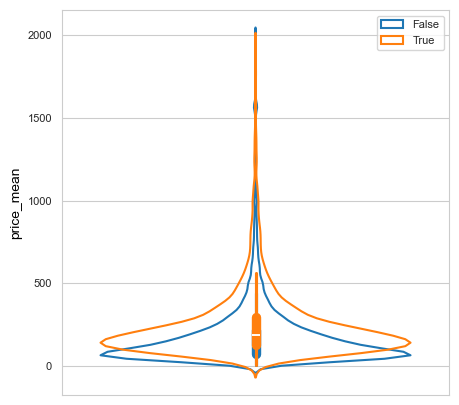

In [39]:
plt.figure(figsize=(5,5))
sns.violinplot(data=stars, y='price_mean', fill=False, hue='host_is_superhost', dodge=False, split=False)
plt.legend()
plt.show()

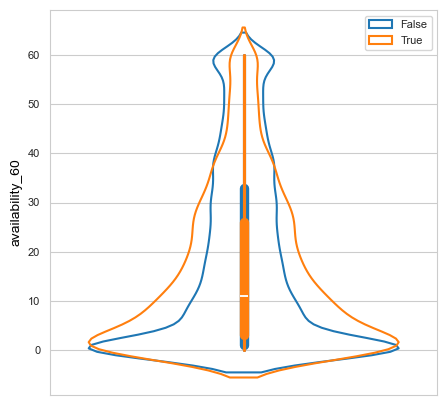

In [40]:
plt.figure(figsize=(5,5))
sns.violinplot(data=stars, y='availability_60', fill=False, hue='host_is_superhost', dodge=False, split=False)
plt.legend()
plt.show()

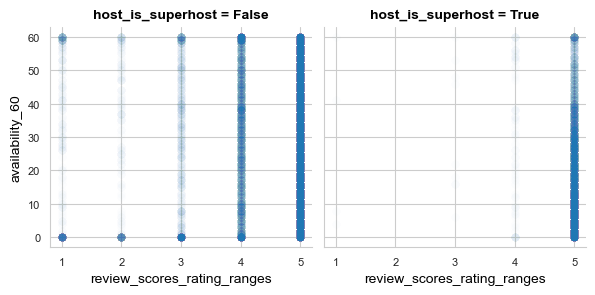

In [41]:
g = sns.FacetGrid(data=stars, col='host_is_superhost', margin_titles=True)
g.map(sns.scatterplot, 'review_scores_rating_ranges', 'availability_60', alpha=0.01)

plt.show()

In [42]:
def annotate_bars(ax=None, fmt='.2f', **kwargs):
    ax = plt.gca() if ax is None else ax
    for p in ax.patches:
         ax.annotate('{{:{:s}}}'.format(fmt).format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                     xytext=(0, 5),textcoords='offset points',
                     ha='center', va='center', **kwargs)

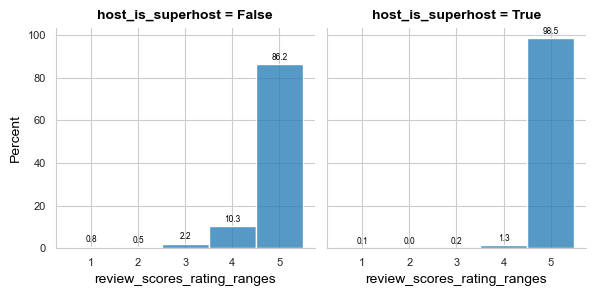

In [43]:
g = sns.FacetGrid(data=stars, col='host_is_superhost', margin_titles=True)
g.map(sns.histplot, 'review_scores_rating_ranges', bins=60, stat='percent')  
g.map(annotate_bars, fmt='0.1f', fontsize=6, color='k')

plt.show()

In [44]:
star_features.remove('price_mean')

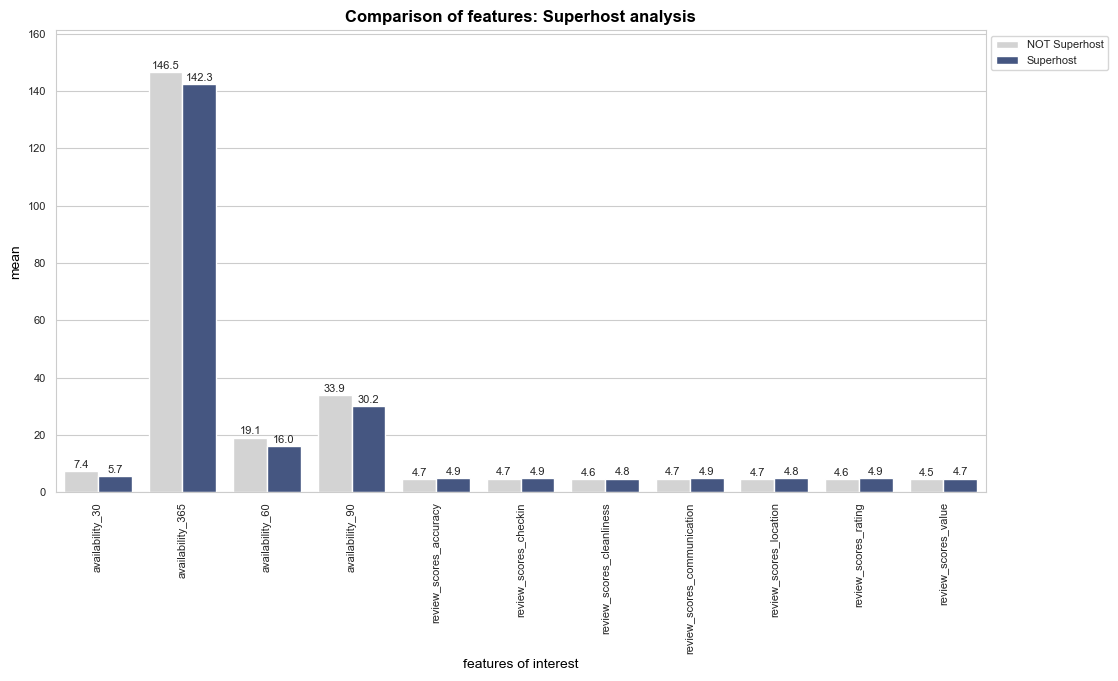

In [45]:
vs.compare_features(stars, star_features.copy(), conda='host_is_superhost == False', condb='host_is_superhost == True', cata_description='NOT Superhost', catb_description='Superhost', 
                    title_extension='Superhost analysis', feature_focus='host_is_superhost')

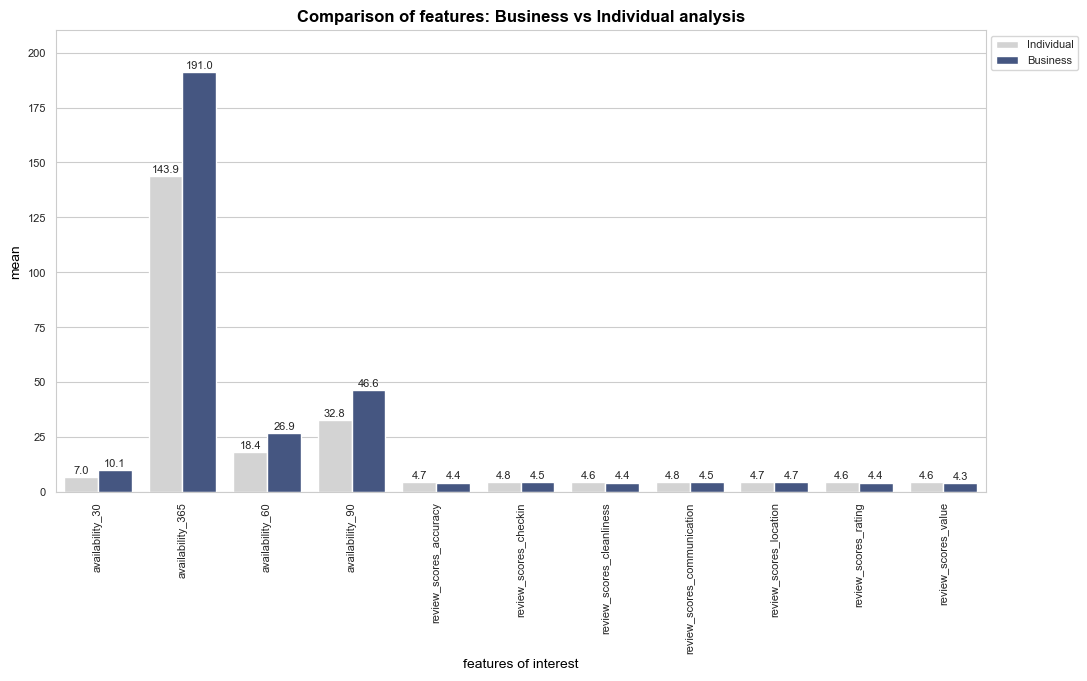

In [46]:
vs.compare_features(stars, star_features.copy(), conda='is_business == False', condb='is_business == True', cata_description='Individual', catb_description='Business', 
                    title_extension='Business vs Individual analysis', feature_focus='is_business')

In [47]:
# remember to look at neighborhood impact too 

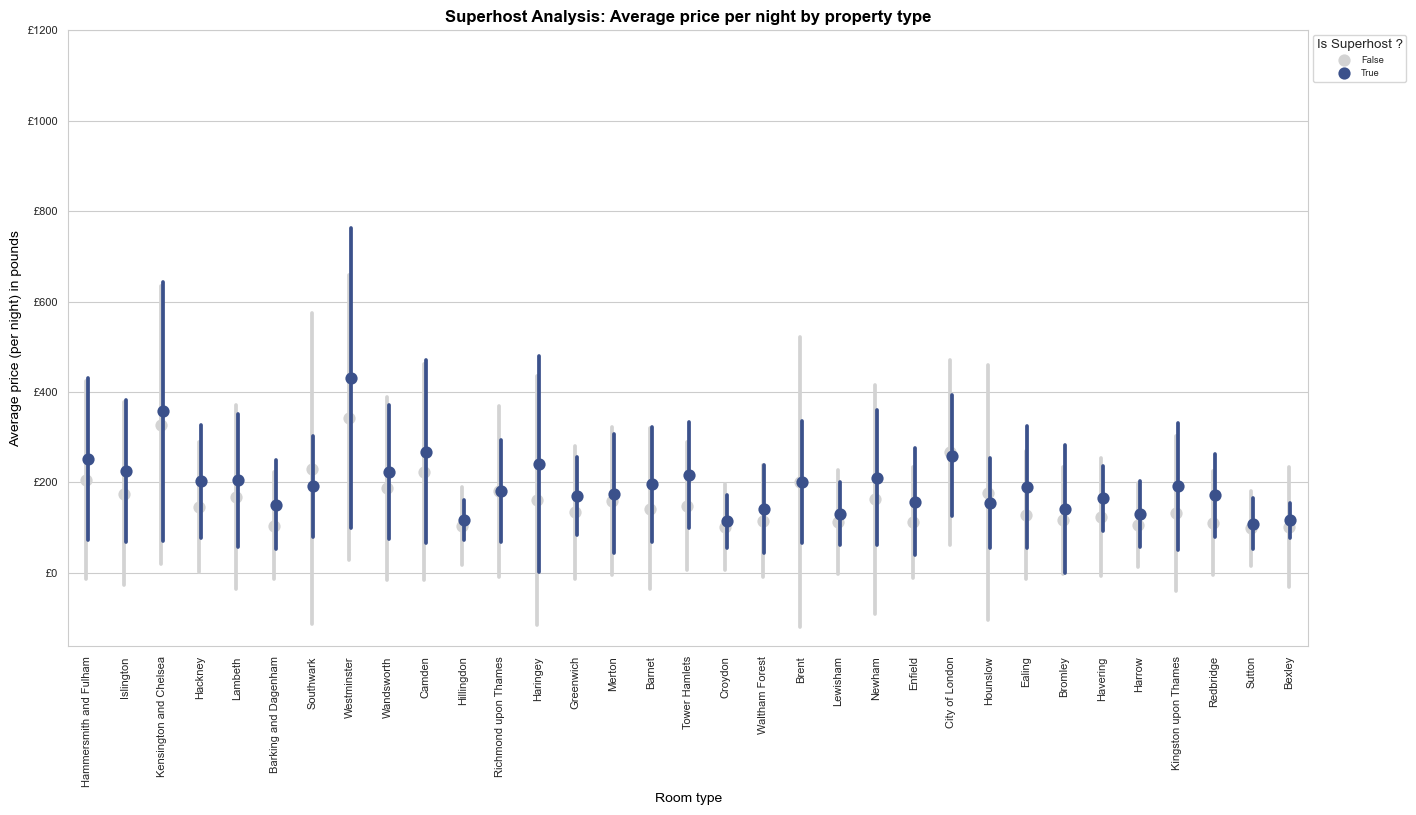

In [48]:
plt.figure(figsize=(16,8))
g = sns.pointplot(data=listings, x='neighbourhood_cleansed', y='price_mean', hue='host_is_superhost', dodge=True, palette={True: BASE_COLOR, False: BASE_GREY}, 
                  errorbar='sd', linestyles="", marker='o')
plt.title('Superhost Analysis: Average price per night by property type')
plt.ylabel('Average price (per night) in pounds')
plt.xlabel('Room type')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Is Superhost ?', fontsize='small', title_fontsize='large')

plt.xticks(rotation=90)
yticks = np.arange(0, 1400, 200)
ylabels = ['£{:1.0f}'.format(tick) for tick in yticks] 
plt.yticks(yticks, ylabels)

plt.show()

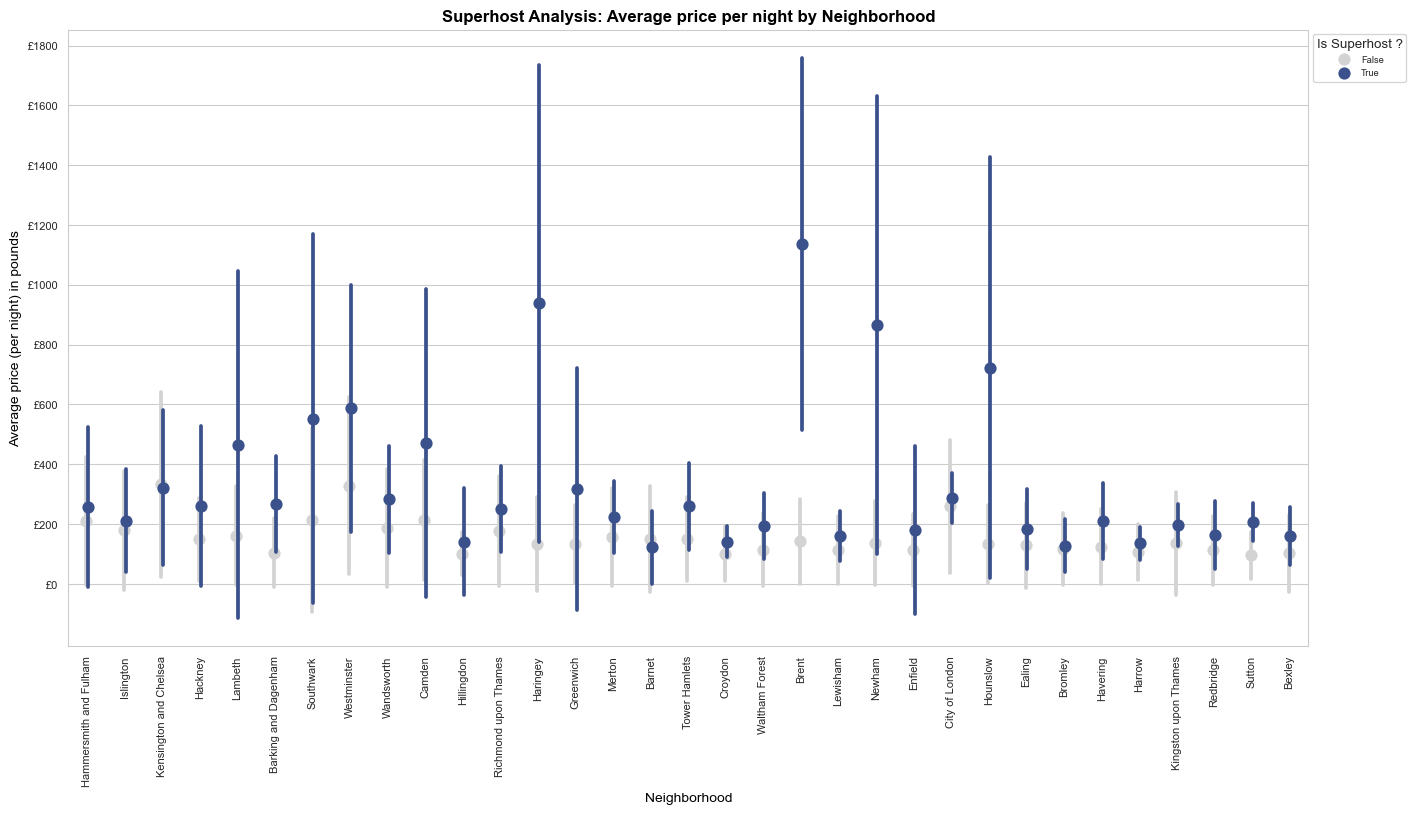

In [49]:
plt.figure(figsize=(16,8))
g = sns.pointplot(data=listings, x='neighbourhood_cleansed', y='price_mean', hue='is_business', dodge=True, palette={True: BASE_COLOR, False: BASE_GREY}, 
                  errorbar='sd', linestyles="", marker='o')
plt.title('Superhost Analysis: Average price per night by Neighborhood')
plt.ylabel('Average price (per night) in pounds')
plt.xlabel('Neighborhood')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Is Superhost ?', fontsize='small', title_fontsize='large')

plt.xticks(rotation=90)
yticks = np.arange(0, 2000, 200)
ylabels = ['£{:1.0f}'.format(tick) for tick in yticks] 
plt.yticks(yticks, ylabels)

plt.show()